Can we leverage sentiment and other post features to build an ML model to predict BTC returns? 

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from modules.data_utils import load_reddit_data, load_bitcoin_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_checkpoint
from modules.lda_labelling import filter_lda_topic

## Load and clean data

In [10]:
df = load_reddit_data()
df = preprocess_data(df)

df_price = load_bitcoin_data()

## Relevance filtering

In [12]:
df = filter_lda_topic(df=df, topic_keywords_file="assets/topic_keywords.csv", topic="Topic 2")

Topic 2 consists of the following keywords: ['market' 'sell' 'invest' 'month' 'day' 'back' 'last' 'next' 'long' 'week'
 'keep' 'bought' 'hold' 'everi' 'right' 'feel' 'drop' 'stock' 'happen'
 'dca' 'around' 'sinc' 'first' 'high' 'trade' 'hodl' 'stack' 'never'
 'loan' 'crash']
Removed 4534 rows by filtering on Topic 2!


In [16]:
df.shape

(11048, 26)

## research

In [152]:
func = t["num_comments"].ewm(halflife="8h", times=t["datetime"]).sum()

<Axes: xlabel='datetime'>

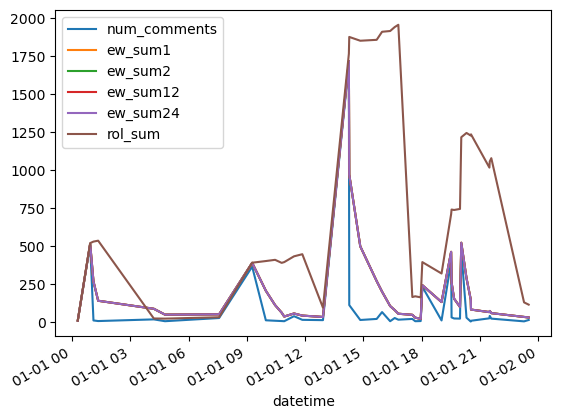

In [149]:
t = df.copy()
t["ew_sum1"] = t["num_comments"].ewm(halflife="1h", times=t["datetime"]).sum()
t["ew_sum2"] = t["num_comments"].ewm(halflife="8h", times=t["datetime"]).sum()
t["ew_sum12"] = t["num_comments"].ewm(halflife="12h", times=t["datetime"]).sum()
t["ew_sum24"] = t["num_comments"].ewm(halflife="24h", times=t["datetime"]).sum()
t["rol_sum"] = t["num_comments"].rolling("3h").sum()

day_filter = "2022-01-01"
t.loc[day_filter][["num_comments", "ew_sum1", "ew_sum2", "ew_sum12", "ew_sum24", "rol_sum"]].plot()

In [141]:
max_time = 23
halflife = np.arange(1,max_time+1,1)
alphas = 1 - np.exp(-np.log(2)/halflife)
weights = [(1-alphas[i])**i for i in range(max_time)]

In [140]:
len(alphas)

23

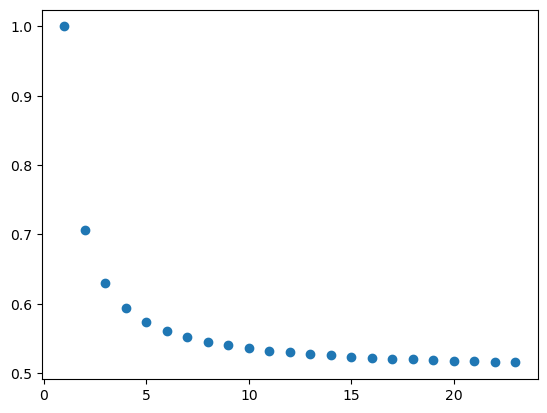

In [143]:
plt.scatter(halflife, weights)

<Axes: xlabel='datetime'>

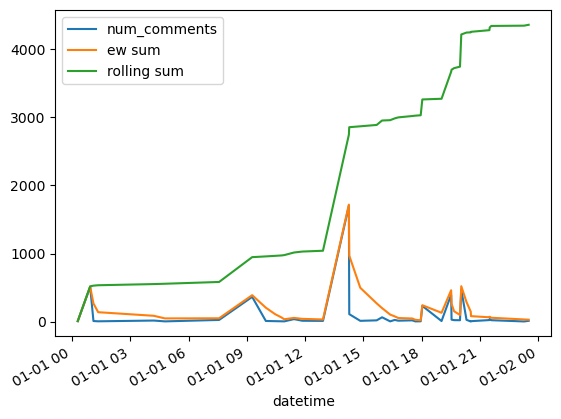

In [124]:
day_filter = "2022-01-01"
pd.concat([
    df.loc[day_filter, "num_comments"].rename("num_comments"),
    df.loc[day_filter, "num_comments"].ewm(halflife="1h", times=df.loc[day_filter, "datetime"]).sum().rename("ew sum"), 
    df.loc[day_filter, "num_comments"].ewm(halflife="1h", times=df.loc[day_filter, "datetime"]).sum().rename("ew sum"), 
    df.loc[day_filter, "num_comments"].rolling("24h").sum().rename("rolling sum")
], axis=1).plot()

<Axes: >

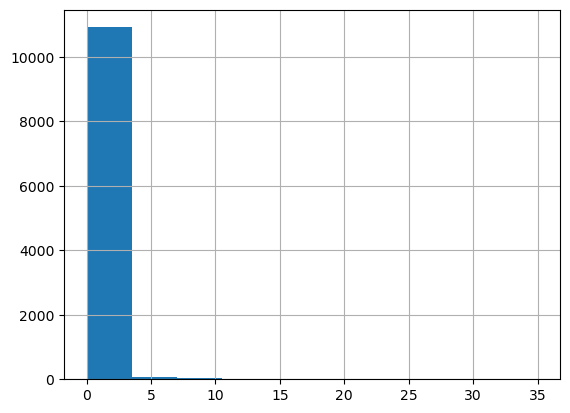

In [27]:
df["total_awards_received"].hist()

In [20]:
post_attributes = ["total_awards_received", "upvote_ratio", "score", "gilded", "total_awards_received", "num_comments", "num_crossposts"]

In [ ]:
def get_aggregate_post_attributes(df, cols: list, lag):
    for col in cols:  
        df[col + "_roll"] = df[col].rolling(lag).mean()
    return df

## Add sentiment scores

In [17]:
# get checkpoint
sentiment_roberta = get_roberta_checkpoint()

# merge sentiment
df = pd.merge(df, sentiment_roberta, how="left", on="submission")
df = df.set_index("datetime")

## Create signals

In [18]:
df["datetime"] = df.index

In [19]:
from modules.signals import get_sentiment_score
lag = "24h"
df = get_sentiment_score(df, lag, exponential_decay=False, num_comments_weighting=False, alpha_name="alpha_sentiment")
df = get_sentiment_score(df, lag, exponential_decay=False, num_comments_weighting=True, alpha_name="alpha_sentiment_num_com")
df = get_sentiment_score(df, lag, exponential_decay=True, num_comments_weighting=True, alpha_name="alpha_sentiment_num_com_ew")


In [20]:
df_date_col_name = "created"
df_price_date_col_name = "datetime"

df[df_date_col_name] = pd.to_datetime(df[df_date_col_name])
df_price[df_price_date_col_name] = pd.to_datetime(df_price[df_price_date_col_name])

In [21]:
# Sort df2 by timestamp to ensure binary search can be applied
df = df.drop(columns="datetime")
df = df.sort_values(by='datetime')
df["datetime"] = df.index

In [54]:
cols = [col fo r]

# Method to find the closest timestamp in df2 that is less than or equal to the timestamp in df1
def find_closest_below(row, df, col):
    # Filter df2 to only include rows where the timestamp is less than or equal to the current row's timestamp in df1
    eligible_signals = df[df['datetime'] <= row['datetime']]
    # If there are no eligible timestamps in df2, return NaN or some default value
    if eligible_signals.empty:
        return pd.NA
    else:
        # Return the signal of the closest timestamp
        return eligible_signals.iloc[-1][col]

# Apply the function to df1
for col in cols:
    df_price[f'signal_{col}'] = df_price.apply(find_closest_below, df=df, axis=1, col=col)


In [55]:
# Sort df2 by timestamp to ensure binary search can be applied
df = df.drop(columns="datetime")
df = df.sort_values(by='datetime')
df["datetime"] = df.index

# Method to find the closest timestamp in df2 that is less than or equal to the timestamp in df1
def find_closest_below(row, df):
    # Filter df2 to only include rows where the timestamp is less than or equal to the current row's timestamp in df1
    eligible_signals = df[df['datetime'] <= row['datetime']]
    # If there are no eligible timestamps in df2, return NaN or some default value
    if eligible_signals.empty:
        return pd.NA
    else:
        # Return the signal of the closest timestamp
        return eligible_signals.iloc[-1]['alpha_weighted_sentiment']

# Apply the function to df1
df_price['signal_weighted'] = df_price.apply(find_closest_below, df=df, axis=1)

In [57]:
df_price

,datetime,open,open_lag_5,perf_5,signal,signal_weighted
0,2022-01-01 00:00:00,46220.00,46666.97,0.009670,<NA>,<NA>
1,2022-01-01 01:00:00,46663.14,45707.67,-0.020476,0.0,0.0
2,2022-01-01 02:00:00,46779.88,45888.94,-0.019045,0.0,0.0
3,2022-01-01 03:00:00,46810.78,46329.08,-0.010290,0.0,0.0
4,2022-01-01 04:00:00,46806.83,46320.28,-0.010395,0.0,0.0
...,...,...,...,...,...,...
8732,2022-12-30 20:00:00,16516.91,16400.46,-0.007050,0.20755,-0.691192
8733,2022-12-30 21:00:00,16550.00,16550.09,0.000005,0.20755,-0.691192
8734,2022-12-30 22:00:00,16581.89,16549.00,-0.001983,0.20755,-0.691192
8735,2022-12-30 23:00:00,16571.82,16524.49,-0.002856,0.20755,-0.691192


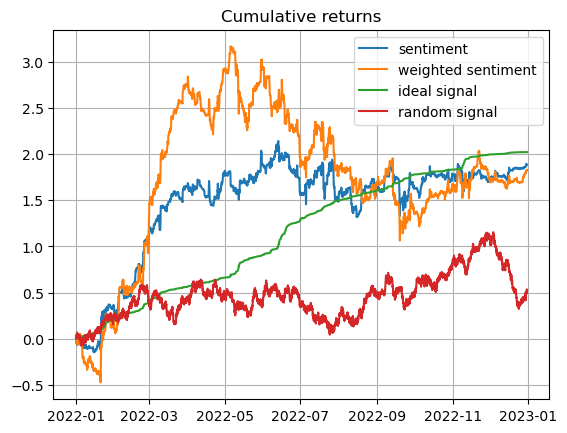

In [61]:
df_price["real_sentiment"] = df_price[f"perf_5"] * df_price["signal"]
df_price["real_weighted_sentiment"] = df_price[f"perf_5"] * df_price["signal_weighted"]

# df_price["random_signal"] = np.random.uniform(low=-1, high=1, size=len(df_price))
df_price["random_signal"] = np.random.normal(0, 0.01, size=len(df_price))

plt.plot(df_price["datetime"], df_price["real_sentiment"].cumsum(), label="sentiment")
plt.plot(df_price["datetime"], df_price["real_weighted_sentiment"].cumsum(), label="weighted sentiment")
plt.plot(df_price["datetime"], (df_price[f"perf_5"]**2).cumsum(), label="ideal signal") # TODO: should we square it?
plt.plot(df_price["datetime"], df_price["random_signal"].cumsum(), label="random signal")

plt.title("Cumulative returns")
plt.grid()
plt.legend()